## Chapter 12 - Multilevel Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

from scipy.special import expit

%matplotlib inline

### 12.1 Example: Multilevel tadpoles

In [2]:
df = pd.read_csv('data/reedfrogs.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
density     48 non-null int64
pred        48 non-null object
size        48 non-null object
surv        48 non-null int64
propsurv    48 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ KB


In [3]:
df.head(10)

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9
8,10,pred,big,4,0.4
9,10,pred,big,9,0.9


#### Model definition

In [5]:
with pm.Model() as multilevel_tadpoles:
    
    # Hyperpriors
    alpha = pm.Normal('alpha', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    # Prior for tank intercepts
    alpha_tank = pm.Normal('alpha_tank', alpha, sigma, shape=df.index.size)
    
    # Log odds per tank
    theta = pm.Deterministic('theta', pm.invlogit(alpha_tank))
    
    # Likelihood
    like = pm.Binomial('like', n=df.density.values, p=theta, observed=df.surv)        

In [6]:
with multilevel_tadpoles:
    trace = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 139.42:   8%|███▉                                              | 15680/200000 [00:02<00:27, 6813.56it/s]
Convergence archived at 16100
Interrupted at 16,100 [8%]: Average Loss = 198.06
100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:06<00:00, 674.56it/s]


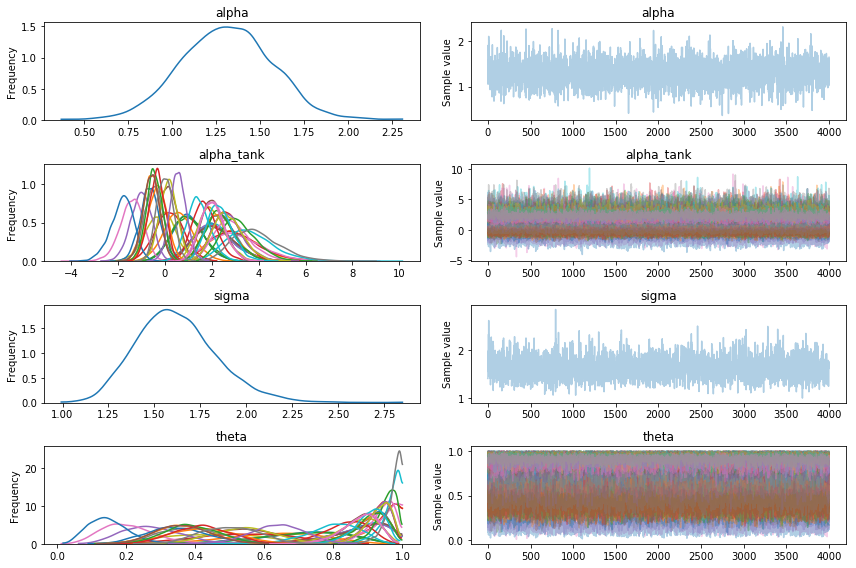

In [7]:
pm.traceplot(trace);

#### Figure 12.1
Note:
- The shrinkage towards the 'across-tanks' estimate.
- Differences in degree of shrinkage for the tank sizes. The smaller the tank, the stronger the shrinkage.
- Stronger estimate shrinkage for observations that lie further away from average.

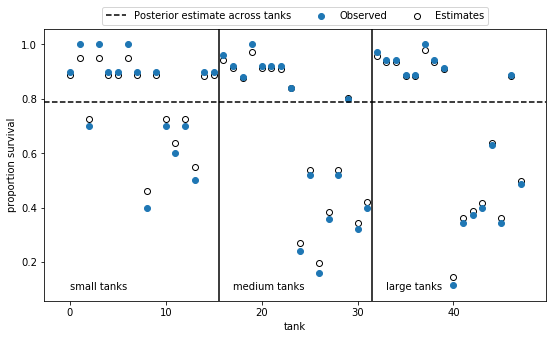

In [44]:
plt.figure(figsize=(9,5))
# Observed
plt.scatter(df.index, df.propsurv, label='Observed')
# Estimates
plt.scatter(df.index, expit(np.median(trace['alpha_tank'], axis=0)),
            facecolors='w', edgecolor='k', zorder=0, label='Estimates')
# Estimate across tanks
plt.axhline(y=expit(np.median(trace['alpha'])), ls='dashed', color='k', label='Posterior estimate across tanks')

# Tank sizes (df.density)
[plt.axvline(x=x, color='k') for x in [15.5, 31.5]]
for x, t in zip([0, 17, 33], ['small', 'medium', 'large']):
    plt.text(x, 0.1, '{} tanks'.format(t))
    
plt.xlabel('tank')
plt.ylabel('proportion survival')
plt.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.1));